## Notes

**Accessing Data**

data['data'] -> list with options data for all expiration dates<br>
data['data'][0]['options'] -> all call/put options for first expiration date<br>
data['data'][0]['options']['CALL'] -> all call options data for first expiration date<br>
data['data'][0]['options']['CALL'][0] -> first call option data for first expiration date<br>

Example Option Data for data['data'][0]['options']['CALL'][0]:

{'contractName': 'AAPL201231C00085000', 'contractSize': 'REGULAR', 'currency': 'USD', 'type': 'CALL', 'inTheMoney': 'TRUE', 'lastTradeDateTime': '2020-12-23 10:32:03', 'expirationDate': '2020-12-31', 'strike': 85, 'lastPrice': 46.55, 'bid': 46.85, 'ask': 47.15, 'change': 5.2, 'changePercent': 0.1258, 'volume': 39, 'openInterest': 182, 'impliedVolatility': 100.0435, 'delta': 0.9994, 'gamma': 0.0001, 'theta': -0.0065, 'vega': 0.0004, 'rho': 0.0163, 'theoretical': 47, 'intrinsicValue': 0, 'timeValue': 0, 'updatedAt': '2020-12-24 19:16:06', 'daysBeforeExpiration': 6}

## Imports

In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime
from IPython import display

In [2]:
from secrets import IEX_CLOUD_API_TOKEN, EOD_HISTORICAL_DATA_API_TOKEN

## Functions

**Function: createDatesStringArray**<br>

Creates a string array of dates with given start date, difference between them (default: 1 week), and the size of
the array. The start date is inclusive

In [3]:
def createDatesStringArray(startDate = datetime.date.today(), deltaDays = 7, N = 5):
    nextDate = startDate
    datesStringArray = []
    for i in range(N):
        datesStringArray.append(str(nextDate))
        tdelta = datetime.timedelta(days=deltaDays)
        nextDate = nextDate + tdelta
    return(datesStringArray)

**Function: createOptionsArrays**

Returns an array of breakeven prices, strike prices, and last prices for options of a specific type. The arrays are in the same order. Only includes the values for which the difference between the strike and current value of the stock is below a threshold (default: +/- 25%) AND only includes In The Money Options

In [4]:
def createOptionsArrays(data, optionType, maxDelta=0.25):
    
    latestPrice = data['lastTradePrice']
    optionsData = data['data'][0]['options'][optionType]
    
    breakEvensArray = []
    strikeArray = []
    lastPriceArray = []

    for option in optionsData:
        
        strike = option['strike']
        lastPrice = option['lastPrice']

        if not(lastPrice is None):
            breakeven = strike + lastPrice
            breakEvenPercent = abs(strike - latestPrice)/latestPrice
        else:
            continue
            
        if optionType == 'CALL':
            if (strike > latestPrice) and (breakEvenPercent < maxDelta):
                breakEvensArray.append(breakeven)
                strikeArray.append(strike)
                lastPriceArray.append(lastPrice)
                
        if optionType == 'PUT':
            if (strike < latestPrice) and (breakEvenPercent < maxDelta):
                breakEvensArray.append(breakeven)
                strikeArray.append(strike)
                lastPriceArray.append(lastPrice)
    
    return breakEvensArray, strikeArray, lastPriceArray

**Function: createOptionStrikesVPricePlot**

This function creates the options strikes vs price plots for the specified symbol and date.

In [5]:
def createOptionStrikesVPricePlot(data, title):
    
    # Parse the data
    latestPrice = data['lastTradePrice']
    callBreakEvensArray, callStrikeArray, callLastPriceArray = createOptionsArrays(data, 'CALL')
    putBreakEvensArray, putStrikeArray, putLastPriceArray = createOptionsArrays(data, 'PUT')
    
    # Create the plots
    if (len(putStrikeArray) > 0) or (len(callStrikeArray) > 0):
        fig1, ax1 = plt.subplots()
        ax1.axvline(x=latestPrice, label='Last Price', linewidth=2, color='r')
        
        ax1.plot(callStrikeArray, callLastPriceArray, label='CALLS')
        ax1.plot(putStrikeArray, putLastPriceArray, label='PUTS')
    
        ax1.set_xlabel('Strike')
        ax1.set_ylabel('Premium')
        ax1.legend()
        ax1.set_title(title)

**Function: updateOptionStrikesVPricePlot**

This function updates the options strikes vs price decay plot for the specified symbol.

In [6]:
def updateOptionStrikesVPricePlot(ax, data, callsLabel, putsLabel):
    
    callBreakEvensArray, callStrikeArray, callLastPriceArray = createOptionsArrays(data, 'CALL')
    putBreakEvensArray, putStrikeArray, putLastPriceArray = createOptionsArrays(data, 'PUT')
    
    if (len(putStrikeArray) > 0) or (len(callStrikeArray) > 0):
        ax.plot(callStrikeArray, callLastPriceArray, label = callsLabel)
        ax.plot(putStrikeArray, putLastPriceArray, label = putsLabel)

**Function: animationFrame**

This function is used by FuncAnimation to update the frame

In [7]:
def animate(frame):

    callsCurve.set_data(callStrikeArrays[frame], callLastPriceArrays[frame])
    callsCurve.set_label('Call')
    putsCurve.set_data(putStrikeArrays[frame], putLastPriceArrays[frame])
    putsCurve.set_label('Put')

    ax.set_title(f'{symbol} Options Strike vs Premium for Expiration: {datesArray[frame]}')
    ax.legend()
    
    return callsCurve, putsCurve

## Main Run

**First run:**

Each symbol and expiration date has its own plot

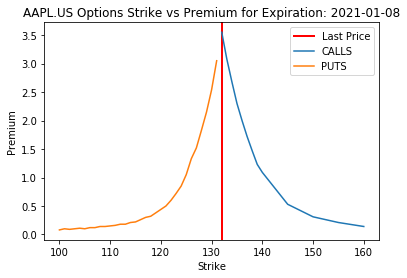

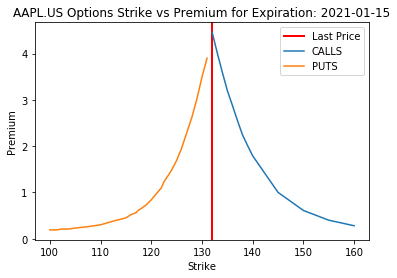

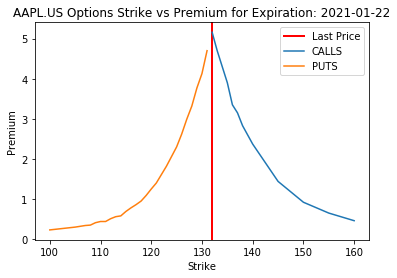

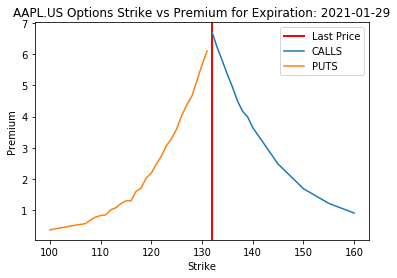

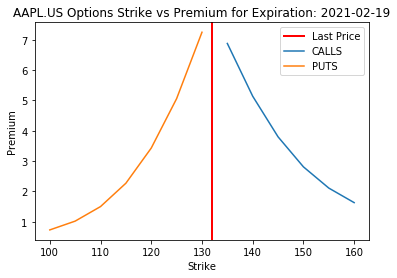

In [8]:
%matplotlib inline

# List of symbols to loop over
symbols = ['AAPL.US']

# List of Expiration dates to loop over
expirationDates = createDatesStringArray(datetime.date(2021, 1, 8), 7, 10)

# Loop over all symbols and dates
for symbol in symbols:
    
    for date in expirationDates:
        
        # Make the API call
        api_base_url = 'https://eodhistoricaldata.com/api/'
        api_endpoint_url = f'options/{symbol}/'
        api_token_url = f'?api_token={EOD_HISTORICAL_DATA_API_TOKEN}'
        api_optional_url = f'&from={date}&to={date}'

        api_url = api_base_url + api_endpoint_url + api_token_url + api_optional_url
        
        data = requests.get(api_url).json()

        # Create the plot if the expiration date has any options data
        if not(data['data'] == []):
            title = f'{symbol} Options Strike vs Premium for Expiration: {date}'
            createOptionStrikesVPricePlot(data, title)

**Second run:**

Each symbol has its own plot but plot all expirations on one plot to compare

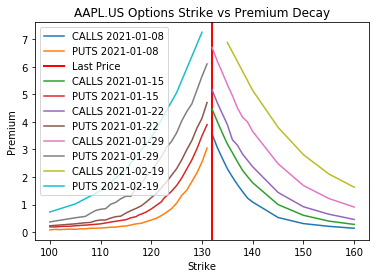

In [9]:
%matplotlib inline

# List of symbols to loop over
symbols = ['AAPL.US']

# List of Expiration dates to loop over
expirationDates = createDatesStringArray(datetime.date(2021, 1, 8), 7, 10)

# Loop over all symbols and dates
for symbol in symbols:
    
    i = 1
    
    fig, ax = plt.subplots()
    ax.set_xlabel('Strike')
    ax.set_ylabel('Premium')
    ax.set_title(f'{symbol} Options Strike vs Premium Decay')
    
    for date in expirationDates:
        
        # Make the API call
        api_base_url = 'https://eodhistoricaldata.com/api/'
        api_endpoint_url = f'options/{symbol}/'
        api_token_url = f'?api_token={EOD_HISTORICAL_DATA_API_TOKEN}'
        api_optional_url = f'&from={date}&to={date}'

        api_url = api_base_url + api_endpoint_url + api_token_url + api_optional_url
        
        data = requests.get(api_url).json()

        # Create the plot if the expiration date has any options data
        if data['data'] != []:
            callsLabel = 'CALLS ' + str(date)
            putsLabel = 'PUTS ' + str(date) 
            updateOptionStrikesVPricePlot(ax, data, callsLabel, putsLabel)
            
        # Create the line of current price to separate the puts and calls (only needs to be done once)
        if i==1:
            latestPrice = data['lastTradePrice']
            ax.axvline(x=latestPrice, label='Last Price', linewidth=2, color='r')
            
        i += 1
        
    ax.legend()

**Third run:**

For each symbol, animate how the premium changes as the expiration date increases

In [10]:
%matplotlib tk

# List of symbols to loop over
symbols = ['AAPL.US']

# List of Expiration dates to loop over
expirationDates = createDatesStringArray(datetime.date(2021, 1, 8), 7, 15)

# Loop over all symbols and dates
for symbol in symbols:
    
    i = 1
    
    fig, ax = plt.subplots()
    
    callsCurves = ax.plot([0], [0])
    callsCurve = callsCurves[0]
    putsCurves = ax.plot([0], [0])
    putsCurve = putsCurves[0]
    
    ax.set_xlabel('Strike')
    ax.set_ylabel('Premium')
    
    callStrikeArrays = []
    callLastPriceArrays = []
    putStrikeArrays = []
    putLastPriceArrays = []
    datesArray = []
    
    for date in expirationDates:
        
        # Make the API call
        api_base_url = 'https://eodhistoricaldata.com/api/'
        api_endpoint_url = f'options/{symbol}/'
        api_token_url = f'?api_token={EOD_HISTORICAL_DATA_API_TOKEN}'
        api_optional_url = f'&from={date}&to={date}'

        api_url = api_base_url + api_endpoint_url + api_token_url + api_optional_url
        
        data = requests.get(api_url).json()

        # Create the plot if the expiration date has any options data
        if data['data'] != []:
            callsLabel = 'CALLS ' + str(date)
            putsLabel = 'PUTS ' + str(date) 
            callBreakEvensArray, callStrikeArray, callLastPriceArray = createOptionsArrays(data, 'CALL')
            putBreakEvensArray, putStrikeArray, putLastPriceArray = createOptionsArrays(data, 'PUT')
        
        # Create the line of current price to separate the puts and calls (only needs to be done once)
        if i==1:
            latestPrice = data['lastTradePrice']
            ax.axvline(x=latestPrice, label='Last Price', linewidth=2, color='r')
        
        # Store calls and puts data for animation
        if(len(callStrikeArray) > 0):
            callStrikeArrays.append(callStrikeArray)
            callLastPriceArrays.append(callLastPriceArray)
            putStrikeArrays.append(putStrikeArray)
            putLastPriceArrays.append(putLastPriceArray)
            datesArray.append(str(date))
        
        i += 1

    # Dynamically set x/y limits for the animated plot
    ax.set_xlim(np.min(putStrikeArray[0]), np.max(callStrikeArray[len(callStrikeArray)-1]))
    ax.set_ylim(np.min(callLastPriceArrays[0]), np.max(callLastPriceArrays[len(callLastPriceArrays)-1]))
    
    # Create animation
    animation = FuncAnimation(fig, func=animate, frames=len(callStrikeArrays), interval=100)
    video = animation.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()